# Header 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as dataSplitter
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from scipy.optimize import curve_fit as fitter
import math

In [3]:
df_simple = pd.read_csv("simpleData.csv")
df_simple.head()

,LoanId,OrderId,PortfolioId,NoteId,Invested,InterestRate,Grade,LoanType,Term,PrincipalRemaining,...,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,PURCHASE_PRINCIPAL,PURCHASE_INTEREST,PRINCIPAL_RECEIVED,INTEREST_RECEIVED
0,62127260,133566975,167112082,143275084,25,18.99%,D3,Personal,36,2.679266,...,2.0,8054.0,61.0,1.0,3.0,3.0,25,0,22.320734,8.001124
1,70904954,133566975,167112082,143275086,25,7.99%,A5,Personal,36,1.550690,...,6.0,5113.0,41.0,4.0,0.0,2.0,25,0,23.449310,3.188582
2,87255474,127709459,167112084,138178962,25,7.59%,A3,Personal,36,0.000000,...,3.0,3572.0,57.0,2.0,0.0,2.0,25,0,25.000000,2.844445
3,88535138,127749223,167112084,138149319,25,16.99%,D1,Personal,36,0.000000,...,6.0,6340.0,54.0,0.0,0.0,0.0,25,0,25.000000,7.035707
4,88593479,127709459,167112082,138178963,25,16.99%,D1,Personal,36,0.024581,...,0.0,1687.0,70.0,2.0,0.0,1.0,25,0,24.975419,7.060581


In [4]:
allnames = set(df_simple.columns)
allnames

{'1st Month Payment',
 'Accrual',
 'Grade',
 'INTEREST_RECEIVED',
 'InterestRate',
 'Invested',
 'Loan Issue Date',
 'LoanId',
 'LoanStatusDate',
 'LoanType',
 'NextPaymentDate',
 'Note Issue Date',
 'NoteId',
 'OrderDate',
 'OrderId',
 'PRINCIPAL_RECEIVED',
 'PURCHASE_INTEREST',
 'PURCHASE_PRINCIPAL',
 'PaymentsReceivedToDate',
 'Pending Interest',
 'Pending Principal Payment',
 'PortfolioId',
 'PrincipalRemaining',
 'Status',
 'Term',
 'Trend',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'accept_d',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'dti',
 'dti_joint',
 'emp_length',
 'emp_title',
 'exp_d',
 'fico_range_high',
 'fico_range_low',
 'home_ownership',
 'il_util',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'is_inc_v',
 'last_credit_pull_d',
 'last_fico_rang

Turn the credit score range into estimated credit score

In [5]:
df_simple['credit_score']=(df_simple['fico_range_high']+df_simple['fico_range_low'])/2.
df_simple.drop(columns = ['last_fico_range_high','last_fico_range_low'])
df_simple.head()

,LoanId,OrderId,PortfolioId,NoteId,Invested,InterestRate,Grade,LoanType,Term,PrincipalRemaining,...,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,PURCHASE_PRINCIPAL,PURCHASE_INTEREST,PRINCIPAL_RECEIVED,INTEREST_RECEIVED,credit_score
0,62127260,133566975,167112082,143275084,25,18.99%,D3,Personal,36,2.679266,...,8054.0,61.0,1.0,3.0,3.0,25,0,22.320734,8.001124,667.0
1,70904954,133566975,167112082,143275086,25,7.99%,A5,Personal,36,1.550690,...,5113.0,41.0,4.0,0.0,2.0,25,0,23.449310,3.188582,747.0
2,87255474,127709459,167112084,138178962,25,7.59%,A3,Personal,36,0.000000,...,3572.0,57.0,2.0,0.0,2.0,25,0,25.000000,2.844445,697.0
3,88535138,127749223,167112084,138149319,25,16.99%,D1,Personal,36,0.000000,...,6340.0,54.0,0.0,0.0,0.0,25,0,25.000000,7.035707,687.0
4,88593479,127709459,167112082,138178963,25,16.99%,D1,Personal,36,0.024581,...,1687.0,70.0,2.0,0.0,1.0,25,0,24.975419,7.060581,682.0


Classify the loan as "Charged Off" which as the high risk loans we don't want. Or as "Full Paid" meaning good loan. Don't worry about the other types yet.

In [6]:
df_simple['Status']=df_simple['Status'].replace('Default','Charged Off')
df_simple['Status']=df_simple['Status'].replace('In Grace Period','Charged Off')

Turn the employment length into a number.

In [7]:
def emp_length_map(x):
    if type(x) == str:
        x=x.replace(' years','')
        x=x.replace(' year','')
        x=x.replace('+','')
        x=x.replace('>','')
        x=x.replace('<','')
        x=x.replace(' ','')
    return x

In [8]:
df_simple['emp_length']=df_simple['emp_length'].apply(emp_length_map)
df_simple['emp_length']=df_simple['emp_length'].fillna(0)
set(df_simple['emp_length'])

{0, '1', '10', '2', '3', '4', '5', '6', '7', '8', '9'}

Recode the "Grade" into ordinal numbers. 

In [9]:
def grade_recoding(x):
    if type(x) == str:
        x=x.replace('A1','34')
        x=x.replace('A2','33')        
        x=x.replace('A3','32')        
        x=x.replace('A4','31') 
        x=x.replace('A5','30')        
        x=x.replace('B1','29')        
        x=x.replace('B2','28')        
        x=x.replace('B3','27')        
        x=x.replace('B5','26') 
        x=x.replace('B4','25')        
        x=x.replace('C1','24')        
        x=x.replace('C2','23')        
        x=x.replace('C3','22')        
        x=x.replace('C4','21')        
        x=x.replace('C5','20') 
        x=x.replace('D1','19')        
        x=x.replace('D2','18')        
        x=x.replace('D3','17')        
        x=x.replace('D4','16')        
        x=x.replace('D5','15') 
        x=x.replace('E1','14')        
        x=x.replace('E2','13')        
        x=x.replace('E3','12')        
        x=x.replace('E4','11')        
        x=x.replace('E5','10')
        x=x.replace('F1','9')        
        x=x.replace('F2','8')        
        x=x.replace('F3','7')        
        x=x.replace('F4','6')        
        x=x.replace('F5','5')
        x=x.replace('G1','4')        
        x=x.replace('G2','3')        
        x=x.replace('G3','2')        
        x=x.replace('G4','1')        
        x=x.replace('G5','1')
    return x

In [10]:
df_simple['Grade']=df_simple['Grade'].apply(grade_recoding)
set(df_simple['Grade'])

{'1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '4',
 '5',
 '7',
 '8',
 '9'}

In [11]:
def revol_util_map(x):
    if type(x) == str:
        x=x.replace('%','')
        x=float(x)
    return x
df_simple['revol_util']=df_simple['revol_util'].apply(revol_util_map)

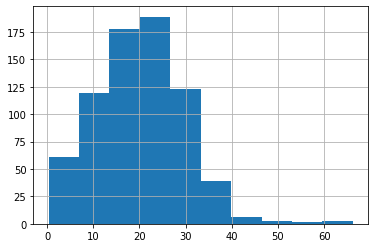

In [12]:
df_simple['dti'].hist()

Charged Off
Current
Fully Paid
Issued
Issuing
Late (16-30 days)
Late (31-120 days)


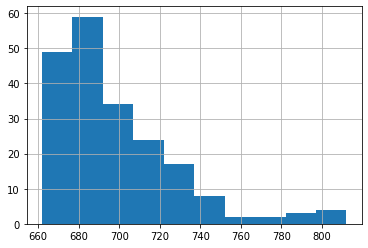

In [13]:
status_groups = df_simple.groupby(['Status'])
for i in status_groups.groups:
    print(i)
paid_fico_hist = status_groups.get_group('Fully Paid')['credit_score'].hist()

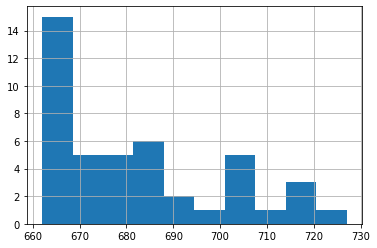

In [14]:
default_fico_hist = status_groups.get_group('Charged Off')['credit_score'].hist()

Investigate the correlation between annual income and paying the loan. Note the exponential (or maybe pareato?) distribution.

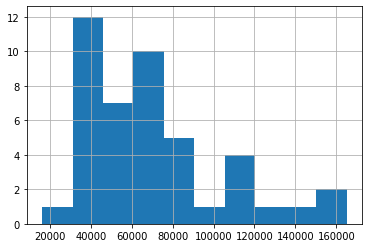

In [15]:
paid_salary_hist = status_groups.get_group('Charged Off')['annual_inc'].hist()

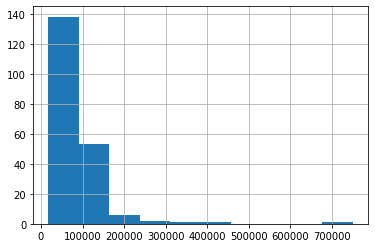

In [16]:
paid_salary_hist = status_groups.get_group('Fully Paid')['annual_inc'].hist()

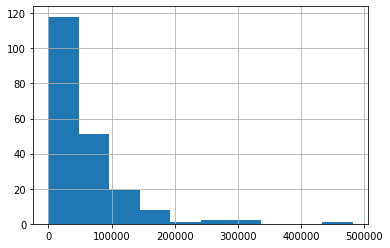

In [17]:
paid_salary_hist = status_groups.get_group('Fully Paid')['total_bal_ex_mort'].hist()

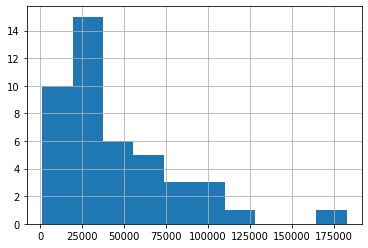

In [18]:
paid_salary_hist = status_groups.get_group('Charged Off')['total_bal_ex_mort'].hist()

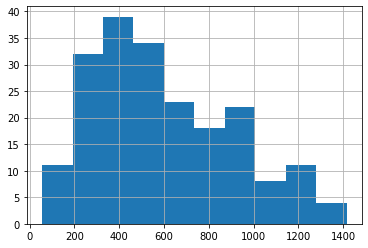

In [19]:
paid_salary_hist = status_groups.get_group('Fully Paid')['installment'].hist()

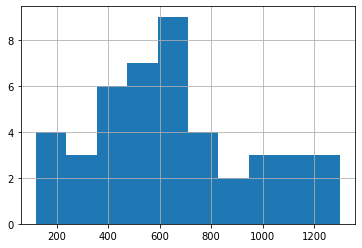

In [20]:
paid_salary_hist = status_groups.get_group('Charged Off')['installment'].hist()

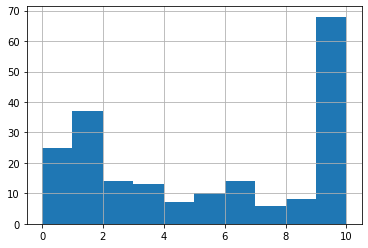

In [21]:
paid_salary_hist = status_groups.get_group('Fully Paid')['emp_length'].dropna().astype(int).hist()

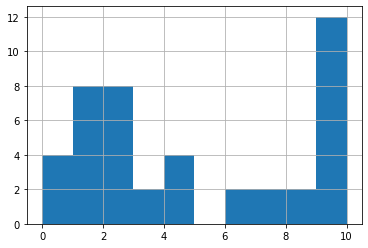

In [22]:
paid_salary_hist = status_groups.get_group('Charged Off')['emp_length'].dropna().astype(int).hist()

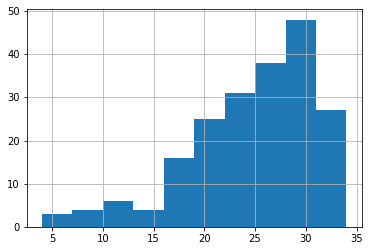

In [23]:
paid_salary_hist = status_groups.get_group('Fully Paid')['Grade'].dropna().astype(int).hist()

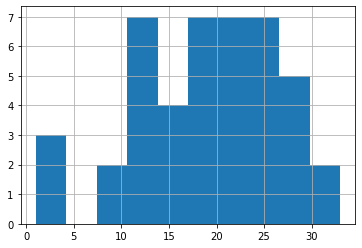

In [24]:
paid_salary_hist = status_groups.get_group('Charged Off')['Grade'].dropna().astype(int).hist()

In [25]:
predictorTitles=['credit_score','annual_inc','total_bal_ex_mort','installment','revol_util','Grade']
df_paid_predictors=status_groups.get_group('Fully Paid')[predictorTitles].astype(float)
df_charged_predictors= status_groups.get_group('Charged Off')[predictorTitles].astype(float)
df_paid_predictors['paid'] = [float(1) for i in range(0,len(df_paid_predictors['credit_score']))]
df_charged_predictors['paid'] = [float(0) for i in range(0,len(df_charged_predictors['credit_score']))]
df_charged_predictors.head(10)

,credit_score,annual_inc,total_bal_ex_mort,installment,revol_util,Grade,paid
7,687.0,48000.0,24646.0,549.77,48.3,17.0,0.0
15,677.0,45000.0,29070.0,596.32,76.5,11.0,0.0
17,717.0,100000.0,1014.0,1163.07,4.9,16.0,0.0
20,687.0,80000.0,45809.0,1300.55,60.2,16.0,0.0
28,702.0,69600.0,96116.0,339.31,32.4,23.0,0.0
31,677.0,130000.0,118108.0,825.99,88.0,21.0,0.0
34,662.0,67000.0,82697.0,488.60,53.6,23.0,0.0
49,672.0,55000.0,31392.0,356.27,7.6,23.0,0.0
59,672.0,165000.0,17069.0,1048.65,75.1,20.0,0.0
61,662.0,81000.0,44423.0,192.01,36.0,26.0,0.0


Remake all the hists with normalized counts.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f770dd0>,
      dtype=object)

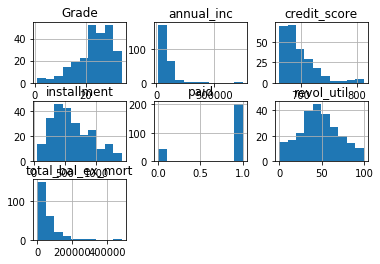

In [26]:
df_predictors = pd.concat([df_paid_predictors,df_charged_predictors])
df_predictors.hist()

Note that these plots tell us how we should scale the data. Grade and installment are approximatly normal. Annual income and total balance amortized are approximatly pareto. Paid is already bernoulli therefore it is min max normalized. Employment length is approximatly uniform so it should be min-max normalized. Credit score is approximatly exponential.

   credit_score  annual_inc  total_bal_ex_mort  installment  revol_util  \
2      0.233333    0.045999           0.228911    -1.127861   -0.627838   
3      0.166667    0.064089           0.059858     0.875177   -0.046882   
5      0.333333    0.045999           0.103271    -1.340776   -0.219017   
6      0.000000    0.018742           0.020426    -0.660375    0.073612   
8      0.333333    0.080071           0.089614    -0.071288   -0.038276   

      Grade  paid  
2  1.240232   1.0  
3 -0.639513   1.0  
5  1.384828   1.0  
6 -1.796280   1.0  
8 -0.350322   1.0  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122d451d0>,
      dtype=object)

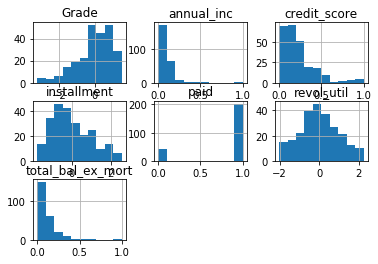

In [28]:
print(df_predictors.head())
df_predictors.hist()

In [30]:
inc_pareto_mles=stats.pareto.fit(df_predictors['annual_inc'].dropna())
pareto_sample = stats.pareto.rvs(inc_pareto_mles[0],size=len(df_predictors['annual_inc'].dropna()),scale=inc_pareto_mles[2],loc=inc_pareto_mles[1])
len(pareto_sample)

246

In [31]:
stats.ks_2samp(df_predictors['annual_inc'].dropna(),pareto_sample)

Ks_2sampResult(statistic=0.15447154471544716, pvalue=0.005581584641227869)

Doesn't really seem to fit the pareto that well. Try exponential.

In [32]:
inc_expo_mles=stats.expon.fit(df_predictors['annual_inc'].dropna())
inc_expo_mles

(0.0, 0.09145936262375086)

In [33]:
expo_sample = stats.expon.rvs(scale=inc_expo_mles[1],size=len(df_predictors['annual_inc'].dropna()))
stats.ks_2samp(df_predictors['annual_inc'].dropna(),expo_sample)

Ks_2sampResult(statistic=0.15853658536585366, pvalue=0.004073577603953272)

Well that fit it a bit better.

# Correlations
There are a lot of linear correlations in the data. Lets see if I can make a statistic that is better than the grade.

In [34]:
df_predictors.corr()

,credit_score,annual_inc,total_bal_ex_mort,installment,revol_util,Grade,paid
credit_score,1.000000,0.114132,0.069407,0.032906,-0.349406,0.440520,0.182326
annual_inc,0.114132,1.000000,0.628650,0.356981,0.085838,0.268331,0.089150
total_bal_ex_mort,0.069407,0.628650,1.000000,0.309363,0.152479,0.168428,0.106279
installment,0.032906,0.356981,0.309363,1.000000,0.124190,-0.096494,-0.067472
revol_util,-0.349406,0.085838,0.152479,0.124190,1.000000,-0.034361,-0.030767
Grade,0.440520,0.268331,0.168428,-0.096494,-0.034361,1.000000,0.303689
paid,0.182326,0.089150,0.106279,-0.067472,-0.030767,0.303689,1.000000


Are there some transformation I can do to make the data more useful?

In [35]:
df_transformed = df_predictors
pca = PCA(4)
pca.fit(df_transformed.drop(['paid'],axis=1))
df_transformed=pd.DataFrame(pca.transform(df_transformed.drop(['paid'],axis=1)), columns=['PCA%i' % i for i in range(4)], index=df_transformed.index)
df_transformed['paid']=df_predictors['paid']
df_transformed.corr()

,PCA0,PCA1,PCA2,PCA3,paid
PCA0,1.000000e+00,-3.102699e-17,-6.092576e-16,2.603581e-16,-0.194954
PCA1,-3.102699e-17,1.000000e+00,4.548639e-16,-6.513659e-17,-0.225489
PCA2,-6.092576e-16,4.548639e-16,1.000000e+00,8.793431e-17,0.075291
PCA3,2.603581e-16,-6.513659e-17,8.793431e-17,1.000000e+00,0.051851
paid,-1.949540e-01,-2.254892e-01,7.529091e-02,5.185060e-02,1.000000


# Regression
This is the interesting result. It will also show if the PCA helps.

In [36]:
train, test = dataSplitter(df_predictors.values,test_size=.1,shuffle=True)
df_train = pd.DataFrame(train,columns=df_predictors.columns)
print(df_train.head(10))
df_test = pd.DataFrame(test,columns=df_predictors.columns)
reg = LinearRegression().fit(df_train.drop('paid',axis=1),df_train['paid'])
print("test score = "+str( reg.score(df_test.drop('paid',axis=1),df_test['paid'])))
print("train score = " + str(reg.score(df_train.drop('paid',axis=1),df_train['paid'])))

   credit_score  annual_inc  total_bal_ex_mort  installment  revol_util  \
0      0.333333    0.045999           0.103271    -1.340776   -0.219017   
1      0.233333    0.069849           0.194915     0.358193   -0.498737   
2      0.000000    0.069168           0.171347    -0.377611    0.280174   
3      0.233333    0.018742           0.027336     0.272024   -0.137253   
4      0.033333    0.059628           0.043006     0.236273    0.947197   
5      0.566667    0.085522           0.119664     0.032376   -0.954894   
6      0.000000    0.075982           0.052631     0.509958    0.258657   
7      0.033333    0.023648           0.056519    -1.550230   -0.369635   
8      0.133333    0.080071           0.137365     0.999636   -0.632141   
9      0.133333    0.100514           0.164352     1.209344   -0.993625   

      Grade  paid  
0  1.384828   1.0  
1 -1.796280   0.0  
2 -0.061130   0.0  
3 -0.350322   1.0  
4 -0.350322   0.0  
5  1.384828   1.0  
6 -2.953046   0.0  
7 -1.796280   

In [37]:
train, test = dataSplitter(df_transformed.values,test_size=.1,shuffle=True)
df_train = pd.DataFrame(train,columns=df_transformed.columns)
print(df_train.head(10))
df_test = pd.DataFrame(test,columns=df_transformed.columns)
reg = LinearRegression().fit(df_train.drop('paid',axis=1),df_train['paid'])
print("test score = "+str( reg.score(df_test.drop('paid',axis=1),df_test['paid'])))
print("train score = " + str(reg.score(df_train.drop('paid',axis=1),df_train['paid'])))

       PCA0      PCA1      PCA2      PCA3  paid
0 -0.013723 -0.011040 -2.309004  0.460919   1.0
1  0.631038 -0.729351 -1.069314 -0.063214   1.0
2 -0.280346 -0.042166  1.930532 -0.029364   1.0
3  0.333557  0.206884  2.688010  0.357334   1.0
4  0.009737  1.374087 -0.777347 -0.029219   1.0
5  0.567784 -1.358372 -0.043605 -0.010741   1.0
6 -1.307081  0.104906 -0.609945 -0.240767   0.0
7  0.091122  1.039940  0.330647  0.137421   1.0
8 -0.905666 -0.055113 -0.394578 -0.203701   1.0
9 -0.644156  0.466758  2.134409 -0.257825   0.0
test score = 0.18107972046796184
train score = 0.08582372818090889


Looks like linear regression does bad either way. What about PLS?

In [38]:
train, test = dataSplitter(df_predictors.values,test_size=.1,shuffle=True)
df_train = pd.DataFrame(train,columns=df_predictors.columns)
print(df_train.head(10))
df_test = pd.DataFrame(test,columns=df_predictors.columns)
reg = PLSRegression(3).fit(df_train.drop('paid',axis=1),df_train['paid'])
print("test score = "+str( reg.score(df_test.drop('paid',axis=1),df_test['paid'])))
print("train score = " + str(reg.score(df_train.drop('paid',axis=1),df_train['paid'])))

   credit_score  annual_inc  total_bal_ex_mort  installment  revol_util  \
0      0.100000    0.025556           0.017817    -0.126374   -0.378242   
1      0.100000    0.114142           0.132865     1.206011    1.485119   
2      0.566667    0.085522           0.119664     0.032376   -0.954894   
3      0.900000    0.052813           0.097952    -1.144720   -1.785446   
4      0.166667    0.056902           0.075695     0.838982    2.027344   
5      0.033333    0.043273           0.078078    -1.175168   -0.029669   
6      0.133333    0.086885           0.154808    -0.231180    1.868119   
7      0.066667    0.099914           0.013329    -0.717494    1.893940   
8      0.333333    0.045999           0.103271    -1.340776   -0.219017   
9      0.333333    0.050088           0.092306     0.211509   -0.735422   

      Grade  paid  
0 -2.230067   1.0  
1 -0.061130   1.0  
2  1.384828   1.0  
3  1.384828   1.0  
4 -0.494917   1.0  
5  0.372657   1.0  
6 -0.639513   1.0  
7  0.806445   

Also does not do well. Can I bag this?

In [446]:
train, test = dataSplitter(df_predictors.values,test_size=.1,shuffle=True)
df_train = pd.DataFrame(train,columns=df_predictors.columns)
df_test = pd.DataFrame(test,columns=df_predictors.columns)
reg = ensemble.BaggingRegressor(LinearRegression(),n_estimators=100,max_samples=100,max_features=5,bootstrap_features=True,oob_score=False).fit(df_train.drop('paid',axis=1),df_train['paid'])
print("test score = "+str( reg.score(df_test.drop('paid',axis=1),df_test['paid'])))
print("train score = " + str(reg.score(df_train.drop('paid',axis=1),df_train['paid'])))

test score = 0.021093231196530504
train score = 0.10192350820310736


Bagging doesn't work either! I am predicting a bernoulli so I should probably use logistic!

In [42]:
df_predictors['paid']=df_predictors['paid'].apply(lambda x: x*2-1) #make it 1 and -1 instead of 1 and 0
train, test = dataSplitter(df_predictors.values,test_size=.1,shuffle=True)
df_train = pd.DataFrame(train,columns=df_predictors.columns)
df_test = pd.DataFrame(test,columns=df_predictors.columns)
reg = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear'),{'tol':[1e-5,1e-4,1e-3],'C':[.01,.1,1,10,100]},cv=3).fit(df_train.drop('paid',axis=1),df_train['paid'])
print("test score = "+str(reg.score(df_test.drop('paid',axis=1),df_test['paid'])))
print("train score = " + str(reg.score(df_train.drop('paid',axis=1),df_train['paid'])))
reg.get_params()

test score = 0.88
train score = 0.8190045248868778


{'cv': 3,
 'error_score': 'raise-deprecating',
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'warn',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l1',
 'estimator__random_state': None,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 'iid': 'warn',
 'n_jobs': None,
 'param_grid': {'tol': [1e-05, 0.0001, 0.001], 'C': [0.01, 0.1, 1, 10, 100]},
 'pre_dispatch': '2*n_jobs',
 're

Works! Does it work with the PCA?

In [44]:
df_predictors['paid']=df_predictors['paid'].apply(lambda x: x*2-1) #make it 1 and -1 instead of 1 and 0
pca.fit(df_transformed.drop(['paid'],axis=1))
df_transformed=pd.DataFrame(pca.transform(df_transformed.drop(['paid'],axis=1)), columns=['PCA%i' % i for i in range(4)], index=df_transformed.index)
df_transformed['paid']=df_predictors['paid']
train, test = dataSplitter(df_transformed.values,test_size=.1,shuffle=True)
df_train = pd.DataFrame(train,columns=df_transformed.columns)
df_test = pd.DataFrame(test,columns=df_transformed.columns)
reg = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear'),{'tol':[1e-5,1e-4,1e-3],'C':[.01,.1,1,10,100]},cv=3).fit(df_train.drop('paid',axis=1),df_train['paid'])
print("test score = "+str( reg.score(df_test.drop('paid',axis=1),df_test['paid'])))
print("train score = " + str(reg.score(df_train.drop('paid',axis=1),df_train['paid'])))
reg.get_params()

test score = 0.8
train score = 0.8235294117647058


{'cv': 3,
 'error_score': 'raise-deprecating',
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'warn',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l1',
 'estimator__random_state': None,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 'iid': 'warn',
 'n_jobs': None,
 'param_grid': {'tol': [1e-05, 0.0001, 0.001], 'C': [0.01, 0.1, 1, 10, 100]},
 'pre_dispatch': '2*n_jobs',
 're

Basically the same with the PCA. I won't use it for simplicity sake.

# Trival Summary
Simple Logistic regression seems to be a good predictor of if the loan will be charged off

## Ideas
1) Not all charged off loans are equally bad. I could weight them by how much of the principle is charged off